In [2]:
library("DESeq2")
# library(limma)
### Packages for plots
library("RColorBrewer")
library("amap")
library(ggplot2)
library("gplots")
# library(ggpubr)
library("pheatmap")
library(plotly)
library("dendextend")
options(warn=-1)

In [3]:
countData <- read.csv('../6Cminus1C_counts.csv', header = TRUE, row.names=1, sep = ",",check.names=FALSE)
genes <- rownames(countData)
metaData <- read.table('../6Cminus1C_sample_annot.txt', header = TRUE, sep = "\t", check.names=FALSE)
rownames(metaData) <- metaData$Sample
metaData$celltype <- factor(metaData$Celltype)
#metaData$batch <- factor(metaData$batch)

countData <- as.data.frame(countData)[,metaData$Sample]
countData <- countData[!duplicated(row.names(countData)),]
dim(countData)
dim(metaData)

[1] 55765    18

[1] 18  3

In [4]:
#parms::tidy: whether the first column of countData is the rownames for the count matrix
ddsFullCountTable <- DESeqDataSetFromMatrix(countData=countData, 
                                  colData=metaData, 
                                  design = ~Celltype, tidy = FALSE) 

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



In [5]:
print(paste0("all genes, number:", dim(ddsFullCountTable)[1]))
ddsFullCountTable <- ddsFullCountTable[rowSums(counts(ddsFullCountTable)) > 20, ] 
print(paste0("exprs genes, number:", dim(ddsFullCountTable)[1]))

[1] "all genes, number:55765"
[1] "exprs genes, number:29335"


In [ ]:
dds <- DESeq(ddsFullCountTable, betaPrior=FALSE) # betaPrior=FALSE?

In [7]:
head(counts(dds, normalized=TRUE), 1)

,iehep-12,iehep-6-1,iehep-6-2,mid-dhep-1,mid-dHep-2,mid-dHep-3,m-dHep-A_r1,m-dHep-A_r2,m-dHep-C_r1,m-dHep-C_r2,m-dHep-D_r1,m-dHep-D_r2,m-dHep-M_r1,m-dHep-M_r2,m-dHep-P_r1,m-dHep-P_r2,m-dHep-S_r1,m-dHep-S_r2
LYPLA1,4827.535,5090.621,5245.813,3531.506,3184.285,3463.712,3087.311,3082.555,2931.664,2883.216,3106.988,3015.731,3506.778,3988.438,3329.332,3353.349,3009.785,3364.214


In [8]:
dds_vst <- vst(dds, blind=TRUE) #
head(assay(dds_vst),1)

,iehep-12,iehep-6-1,iehep-6-2,mid-dhep-1,mid-dHep-2,mid-dHep-3,m-dHep-A_r1,m-dHep-A_r2,m-dHep-C_r1,m-dHep-C_r2,m-dHep-D_r1,m-dHep-D_r2,m-dHep-M_r1,m-dHep-M_r2,m-dHep-P_r1,m-dHep-P_r2,m-dHep-S_r1,m-dHep-S_r2
LYPLA1,12.26151,12.33682,12.37946,11.81932,11.67357,11.792,11.63008,11.62791,11.55742,11.53404,11.63901,11.59712,11.80941,11.99111,11.73625,11.74638,11.59435,11.75093


#### Correlation between samples

corrplot 0.92 loaded



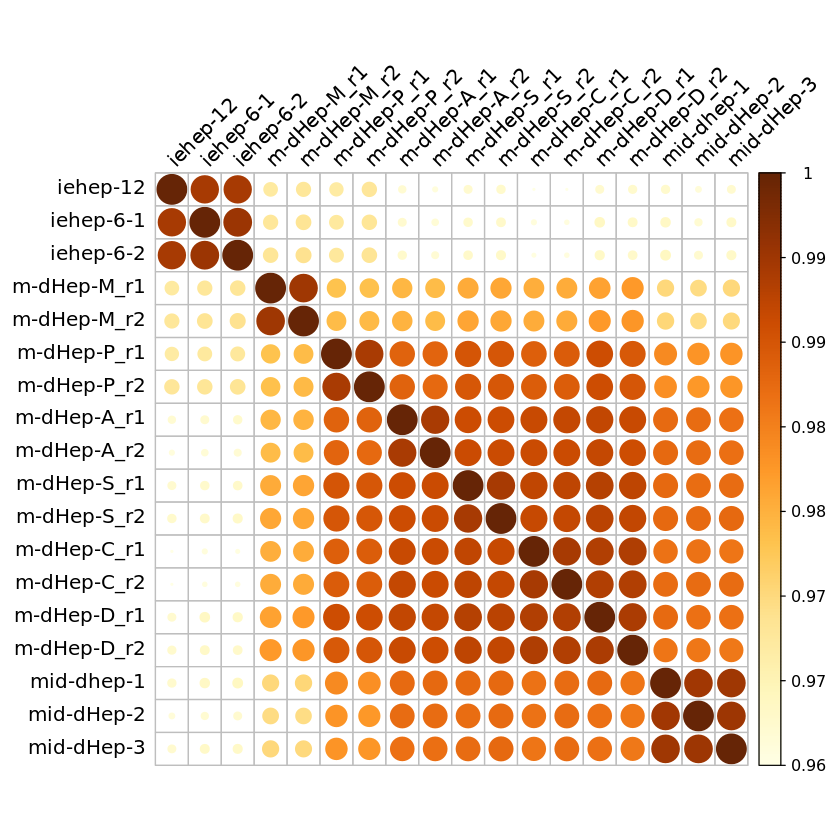

In [10]:
library(corrplot)
res <- cor(assay(dds_vst))
ordered_samps <- c('iehep-12','iehep-6-1','iehep-6-2',
                  'm-dHep-M_r1','m-dHep-M_r2',
                  'm-dHep-P_r1','m-dHep-P_r2',
                  'm-dHep-A_r1','m-dHep-A_r2',
                  'm-dHep-S_r1','m-dHep-S_r2',
                  'm-dHep-C_r1','m-dHep-C_r2',
                  'm-dHep-D_r1','m-dHep-D_r2',
                  'mid-dhep-1','mid-dHep-2','mid-dHep-3')
#pdf(file="./6Cminus1C_corr.20220826.upper.pdf",width=6, height=6)
corrplot(res[ordered_samps, ordered_samps], 
         is.corr=FALSE,
         type = "full", order = "original",  #"original", "AOE", "FPC", "hclust", "alphabet"
         tl.col = "black", tl.srt = 45, tl.cex = 1,
         cl.length = 8)
#dev.off()

#### Heatmap

In [13]:
data <- assay(dds_vst)#assay(dds_vst),normalized_counts
head(data,1)

,iehep-12,iehep-6-1,iehep-6-2,mid-dhep-1,mid-dHep-2,mid-dHep-3,m-dHep-A_r1,m-dHep-A_r2,m-dHep-C_r1,m-dHep-C_r2,m-dHep-D_r1,m-dHep-D_r2,m-dHep-M_r1,m-dHep-M_r2,m-dHep-P_r1,m-dHep-P_r2,m-dHep-S_r1,m-dHep-S_r2
LYPLA1,12.26151,12.33682,12.37946,11.81932,11.67357,11.792,11.63008,11.62791,11.55742,11.53404,11.63901,11.59712,11.80941,11.99111,11.73625,11.74638,11.59435,11.75093


In [14]:
ntop = 5000
rv <- rowVars(data)/rowMeans(data)
select <- order(rv, decreasing = TRUE)[seq_len(min(ntop, 
                                                     length(rv)))]
data <- data[select,]
dim(data)

[1] 5000   18

In [15]:
### Normal zscore
zscore <- t(scale(t(data)))
zscore <- zscore[complete.cases(zscore), ]

In [16]:
# ### roubust z-score = 0.6745(x-median)/mad
# median_ = apply(data,1, median)
# mad_ = apply(data,1,mad)
# zscore = 0.6745*(data - median_)[mad_>0.2,]/mad_[mad_>0.2]
# zscore <- zscore[complete.cases(zscore), ]

In [17]:
dim(zscore)
min(zscore)
max(zscore)

[1] 5000   18

[1] -3.921019

[1] 4.006938

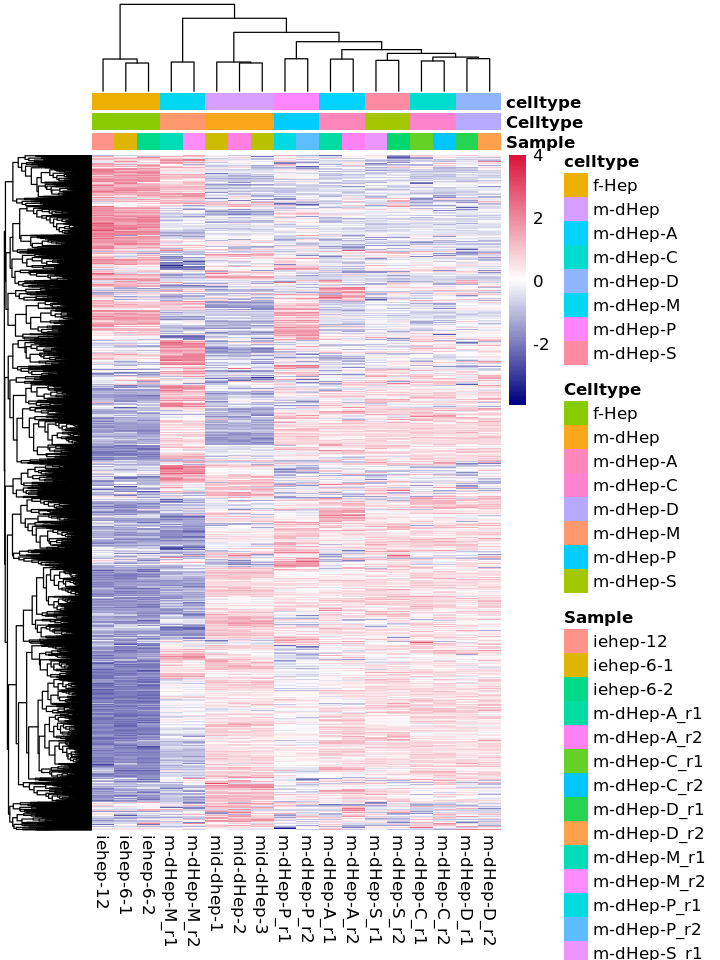

In [18]:
options(repr.plot.width=6, repr.plot.height=8)
hp2 = pheatmap(zscore,
               cluster_row=TRUE, 
               cluster_col=TRUE,
               show_rownames=FALSE,
               annotation_col=metaData,
               clustering_method = "complete", #average
               color = colorRampPalette(c("navyblue", "white", "#DC143C"), bias=1)(100))#clustering_method = "average"

In [19]:
ordered_genes <- rownames(zscore[hp2$tree_row[["order"]],])
ordered_samps <- colnames(zscore[,hp2$tree_col[["order"]]])#

In [20]:
ordered_samps <- c('iehep-12','iehep-6-1','iehep-6-2',
                  'm-dHep-M_r1','m-dHep-M_r2',
                  'm-dHep-P_r1','m-dHep-P_r2',
                  'm-dHep-A_r1','m-dHep-A_r2',
                  'm-dHep-S_r1','m-dHep-S_r2',
                  'm-dHep-C_r1','m-dHep-C_r2',
                  'm-dHep-D_r1','m-dHep-D_r2',
                  'mid-dhep-1','mid-dHep-2','mid-dHep-3')

In [21]:
clusted_zscore<-zscore[ordered_genes,ordered_samps]

In [22]:
clusted_zscore[clusted_zscore < (-2)] = -2
clusted_zscore[clusted_zscore > (2)] = 2

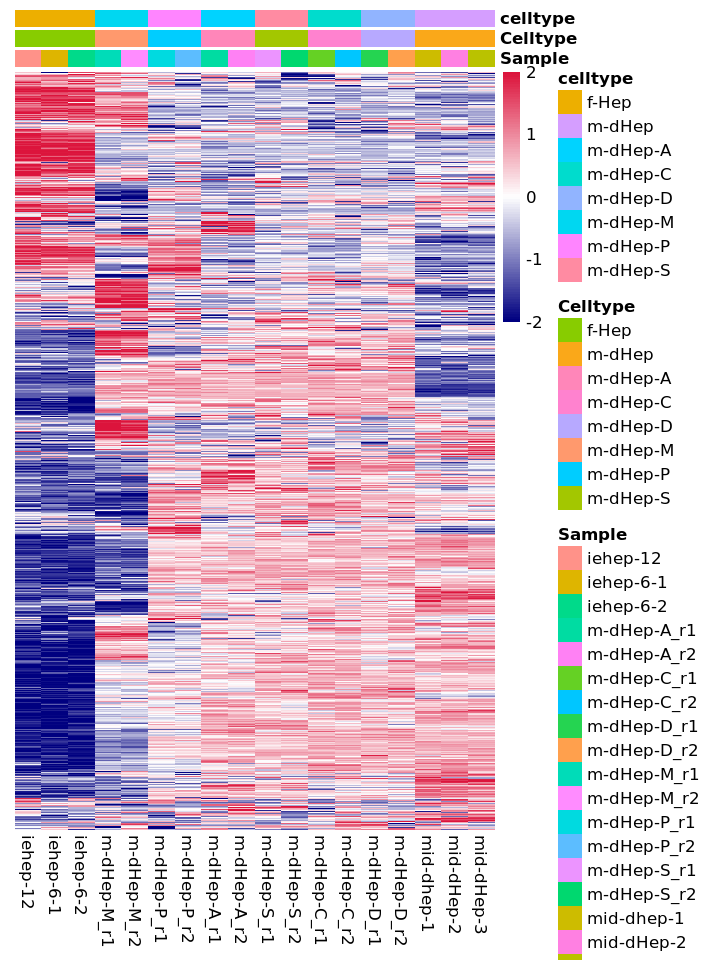

In [23]:
options(repr.plot.width=6, repr.plot.height=8)
hp3 = pheatmap(clusted_zscore,
               cluster_row=FALSE, 
               cluster_col=FALSE,
               show_rownames=FALSE,
               annotation_col=metaData,
               color = colorRampPalette(c("navyblue", "white", "#DC143C"), bias=1)(100),
               border_color='lightgrey',
               cellwidth = 16,)

In [390]:
# pdf(file="./6Cminus1C_heatmap.20220826.pdf",height=6)
# hp3
# dev.off()

#### DEGs

In [9]:
group_name <- "Celltype"
sampleA <- "m-dHep-P"
sampleB <- "m-dHep"

In [17]:
res <- results(dds, contrast=c(group_name, sampleA, sampleB))
res$ID <- rownames(res)

In [25]:
###
baseA <- assay(dds_vst)[, colData(dds)$Celltype == sampleA]
if (is.vector(baseA)){
    baseMeanA <- as.data.frame(baseA)
} else {
    baseMeanA <- as.data.frame(rowMeans(baseA))
}
colnames(baseMeanA) <- sampleA
head(baseMeanA,2)

### 
baseB <- assay(dds_vst)[, colData(dds)$Celltype == sampleB]
if (is.vector(baseB)){
        baseMeanB <- as.data.frame(baseB)
} else {
        baseMeanB <- as.data.frame(rowMeans(baseB))
}
colnames(baseMeanB) <- sampleB
head(baseMeanB,2)

,m-dHep-P
,<dbl>
LYPLA1,11.74131
PHF3,12.49605


,m-dHep
,<dbl>
LYPLA1,11.76163
PHF3,12.42548


In [20]:
res <- cbind(baseMeanA, baseMeanB, as.data.frame(res))
head(res,2)

,m-dHep-P,m-dHep,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,ID
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
LYPLA1,11.74131,11.76163,3555.713,-0.02215264,0.07157157,-0.3095173,0.756928,0.8719704,LYPLA1
PHF3,12.49605,12.42548,5315.109,0.07152027,0.06642222,1.0767522,0.281591,0.4771847,PHF3


In [21]:
DEG =  as.data.frame(res[order(res$padj),])

In [24]:
# write.csv(DEG,'../6CminusP_vs_mHep_fc.csv')

#### KEGG

In [4]:
library("clusterProfiler")
library(enrichplot)
library(pathview)

In [52]:
df <- read.csv('../6CminusP_vs_mHep_fc.csv',row.names=1)

In [53]:
df <- df[(df$log2FoldChange<(-0.5)) & (df$padj<0.01),]
df <- df[complete.cases(df), ]
dim(df)
tail(df,2)

[1] 1448    9

,m.dHep.P,m.dHep,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,ID
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
RP11-54F2.1,7.515033,8.198562,126.2768,-1.005359,0.3312812,-3.03476,0.002407269,0.009987948,RP11-54F2.1
RP11-1415C14.3,7.567260,8.468669,172.8754,-1.244143,0.4099630,-3.03477,0.002407192,0.009987948,RP11-1415C14.3


In [54]:
original_gene_list <- df$log2FoldChange
names(original_gene_list) <- rownames(df)

In [55]:
# omit the na value
gene_list<-na.omit(original_gene_list)
# sort the list in decreasing order (required for clusterProfiler)
gene_list = sort(gene_list, decreasing = TRUE)

Convert gene IDs for gseKEGG function

In [56]:
ids<-bitr(names(original_gene_list), fromType = "SYMBOL", toType = "ENTREZID", OrgDb="org.Hs.eg.db")
dedup_ids = ids[!duplicated(ids[c("SYMBOL")]),]
# Create a new dataframe df2 which has only the genes which were successfully mapped using the bitr function above
df2 = df[rownames(df) %in% dedup_ids$SYMBOL,]
# Create a new column in df2 with the corresponding ENTREZ IDs
df2$Y = dedup_ids$ENTREZID
# Create a vector of the gene unuiverse
kegg_gene_list <- df2$log2FoldChange
# Name vector with ENTREZ ids
names(kegg_gene_list) <- df2$Y
# omit any NA values 
kegg_gene_list<-na.omit(kegg_gene_list)
# sort the list in decreasing order (required for clusterProfiler)
kegg_gene_list = sort(kegg_gene_list, decreasing = TRUE)

'select()' returned 1:1 mapping between keys and columns



Create gseKEGG object

In [57]:
kegg_organism = "hsa"
kk2 <- gseKEGG(geneList     = kegg_gene_list,
               organism     = kegg_organism,
               nPerm        = 10000,
               minGSSize    = 3,
               maxGSSize    = 800,
               pvalueCutoff = 0.05,
               pAdjustMethod = "none",
               keyType       = "ncbi-geneid")

preparing geneSet collections...

GSEA analysis...

leading edge analysis...

done...



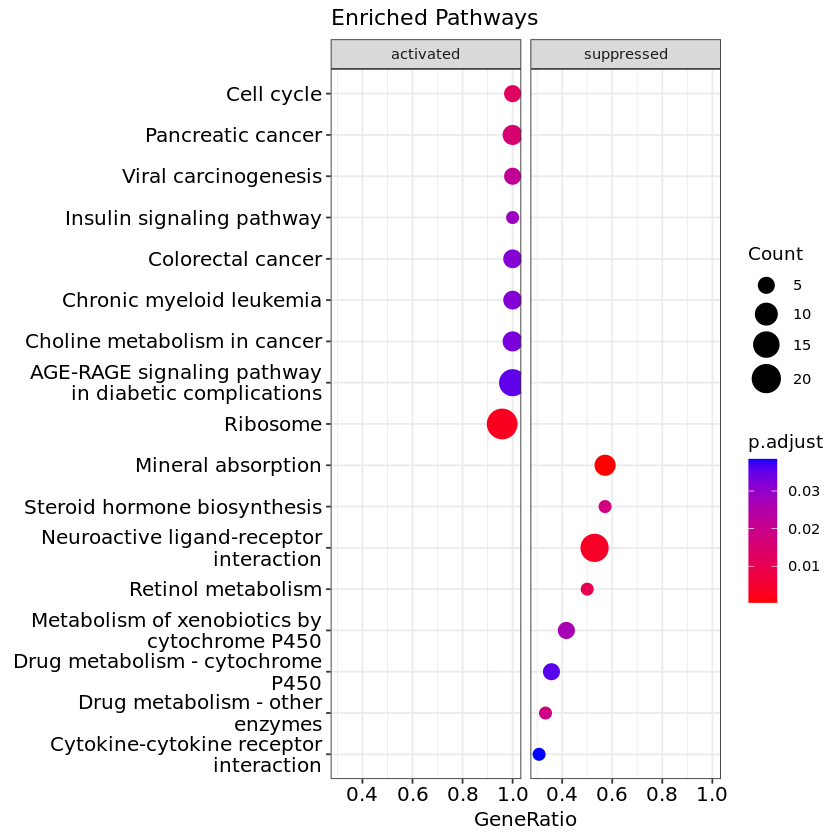

In [58]:
dotplot(kk2, showCategory = 10, title = "Enriched Pathways" , split=".sign") + facet_grid(.~.sign)

In [59]:
head(data.frame(kk2),2)
#write.csv(data.frame(kk2), '../down_genes_in_6CminusP_compared_to_mHep_kegg.csv')

,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalues,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
hsa04978,hsa04978,Mineral absorption,14,-0.8032479,-2.184527,0.0003298516,0.0003298516,0.07742832,67,"tags=57%, list=5%, signal=55%",4494/4493/4501/4502/4495/4496/4490/4499
hsa03010,hsa03010,Ribosome,24,0.3722883,2.198876,0.0029069767,0.0029069767,0.28614812,693,"tags=96%, list=57%, signal=42%",65008/6135/4736/6160/6136/6209/6144/6129/6224/6173/6157/6142/6154/6155/6230/23521/6205/6168/6208/6167/9349/6147/6171


Enrichment map organizes enriched terms into a network with edges connecting overlapping gene sets. In this way, mutually overlapping gene sets are tend to cluster together, making it easy to identify functional modules.

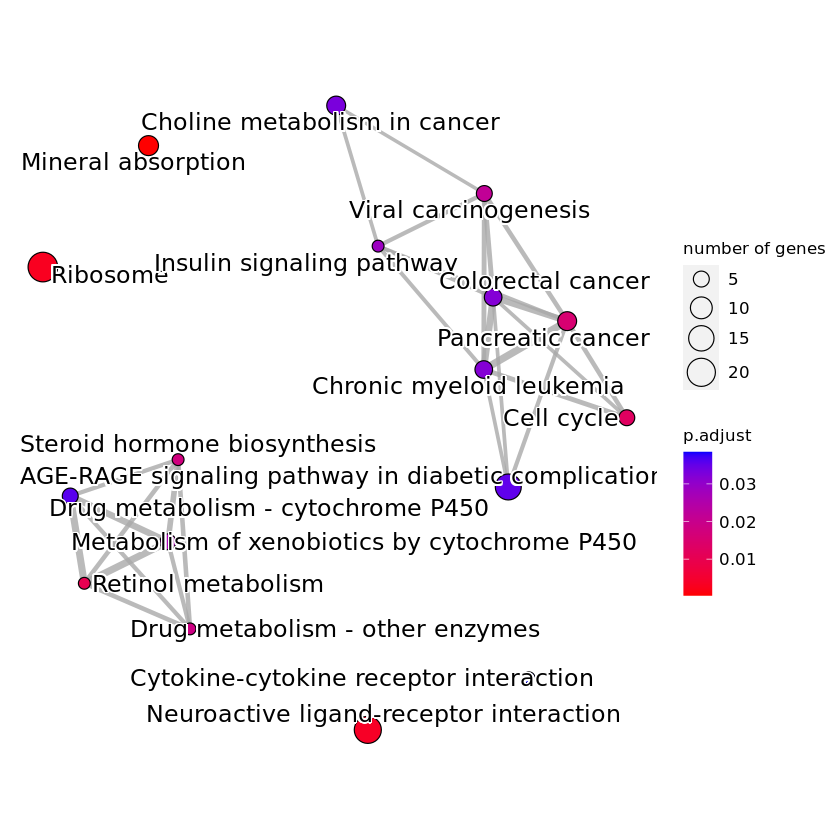

In [60]:
x2 <- pairwise_termsim(kk2)
emapplot(x2)

In [65]:
kegg_organism

[1] "hsa"

In [ ]:
# Produce the native KEGG plot (PNG)
dme <- pathview(gene.data=kegg_gene_list, pathway.id="hsa04978", species = kegg_organism)
# Produce a different plot (PDF) (not displayed here)
# dme <- pathview(gene.data=kegg_gene_list, pathway.id="hsa04978", species = kegg_organism, kegg.native = F)

In [ ]:
knitr::include_graphics("hsa04978.pathview.png")

#### GO analysis

In [ ]:
gse <- gseGO(geneList=gene_list, 
             ont ="ALL", 
             keyType = "SYMBOL", 
             nPerm = 10000, 
             minGSSize = 3, 
             maxGSSize = 800, 
             pvalueCutoff = 0.05, 
             verbose = TRUE, 
             OrgDb = "org.Hs.eg.db", 
             pAdjustMethod = "none")

In [ ]:
require(DOSE)
dotplot(gse, showCategory=10, split=".sign") + facet_grid(.~.sign)